<a href="https://colab.research.google.com/github/abdullah5282/GAN-in-Fashion/blob/main/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q sagemaker transformers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
# import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train),(x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0

4422102/4422102 [==============================] - 1s 0us/step


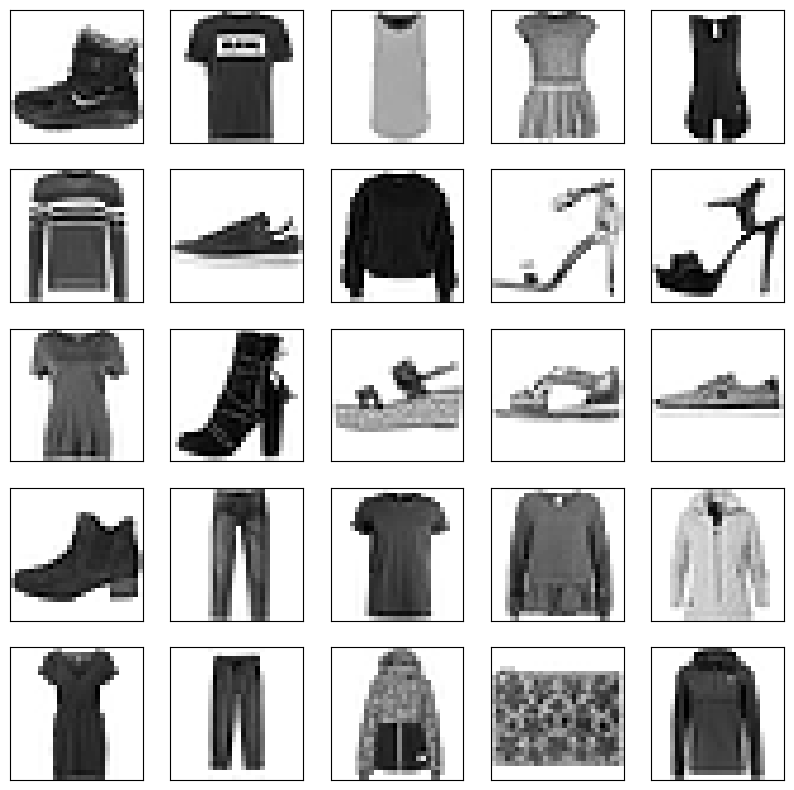

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [ ]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

In [ ]:
num_features=100
generator=keras.models.Sequential([
    keras.layers.Dense(7*7*256, input_shape=[num_features]),
    keras.layers.Reshape([7,7,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128,(5,5),(2,2),padding='same', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5),(2,2), padding='same',activation='tanh')
])

In [ ]:
pip install plot-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 535.6 kB/s eta 0:00:00


In [ ]:
import plot_utils as pu

In [ ]:
noise=tf.random.normal(shape=[1, num_features])
generated_image=generator(noise, training=False)

In [ ]:
discriminator=keras.models.Sequential([
    keras.layers.Conv2D(128,(5,5),(2,2), padding='same',input_shape=[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(512,(5,5),(2,2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.50073]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan=keras.models.Sequential([
    generator, discriminator
])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
seed=tf.random.normal(shape=[batch_size,100])

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator=gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1,epochs))
        for X_batch in dataset:
            noise=tf.random.normal(shape=[batch_size, num_features])
            generated_images=generator(noise)
            X_fake_and_real=tf.concat([generated_images, X_batch], axis=0)
            y1=tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
            discriminator.trainable=True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2=tf.constant([[1.]]*batch_size)
            discriminator.trainable=False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
x_train_dcgan=x_train.reshape(-1,28,28,1)*2. -1

In [ ]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset=dataset.batch(batch_size, drop_remainder=True).prefetch(1)

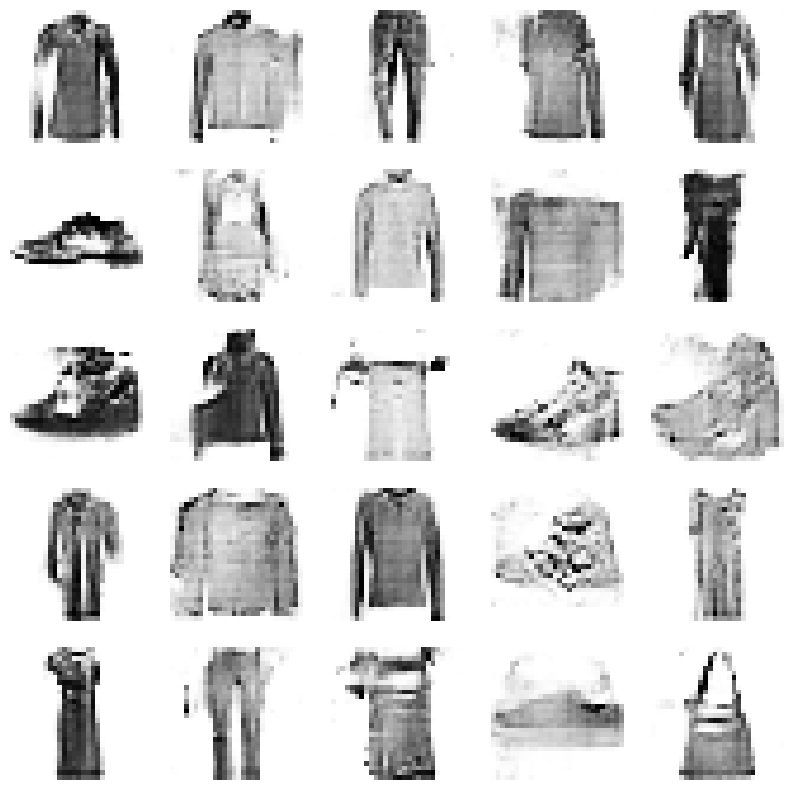

In [ ]:
train_dcgan(gan, dataset, batch_size, num_features, epochs=5)

In [ ]:
noise=tf.random.normal(shape=[batch_size, num_features])
generated_images=generator(noise)
# pu.show(generated_images, 8)

<ipython-input-23-cbfcd642e3ac>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-23-cbfcd642e3ac>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


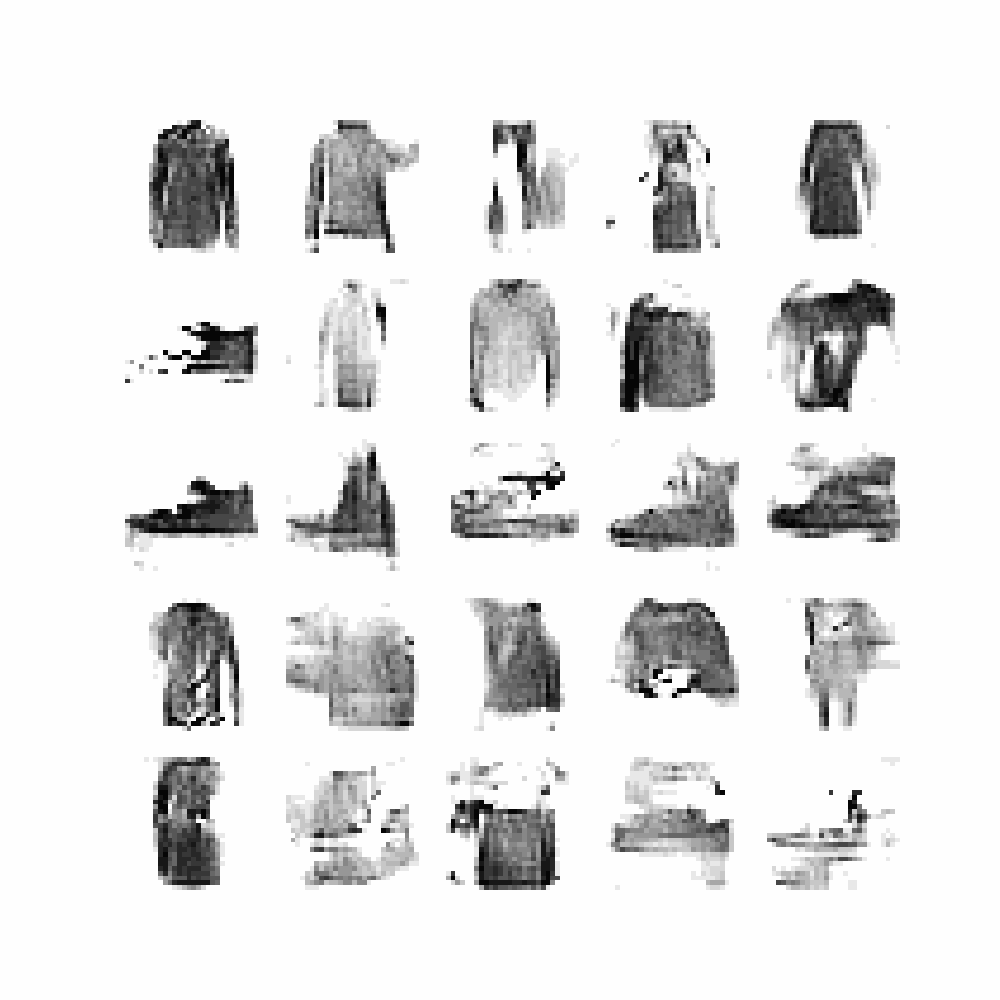

In [ ]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)